In [1]:
from sklearn.preprocessing import MinMaxScaler
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import math
import numpy as np
import torch

#Download dos dados de preço das ações Itau Unibanco com ticker "ITUB4"
df_ITUB4 = yf.download('ITUB4.SA', start="2016-01-01", end="2024-03-31")
#Gerando um novo dataset reduzido, apenas com Data(index), alta e baixa
df_reduced = df_ITUB4[['High', 'Low']]

[*********************100%%**********************]  1 of 1 completed


In [2]:
#Ordenando valores por data
df_reduced = df_reduced.sort_values(by='Date')
#Calculando a média entre alta e baixa e atribuindo a coluna median
df_reduced['Median'] = df_reduced.mean(axis=1)


<function matplotlib.pyplot.show(close=None, block=None)>

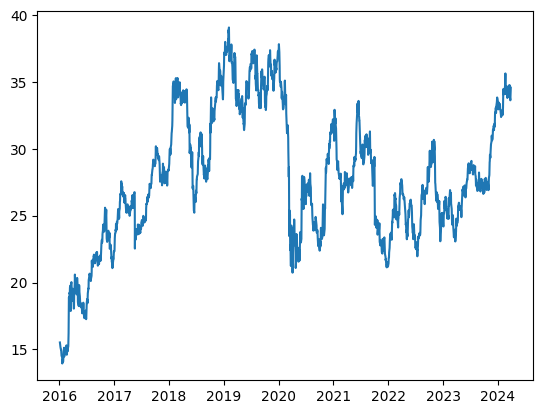

In [3]:
#Gerando gráfico da média de preços da ação
plt.plot(df_reduced['Median'])
plt.show

In [4]:
#Vamos padronizar as médias de valor do ticker
norm = MinMaxScaler(feature_range=(0,1))
normalized = df_reduced.iloc[:, 2:3]
df_reduced['Stand']= norm.fit_transform(normalized.values)

In [5]:
#Retirar eventuais valores nulos
df_reduced = df_reduced.dropna()
#Selecionando a base de treinamento em 80% das observações
df_training = df_reduced['Stand'].iloc[0:math.ceil(len(df_reduced) * 0.8)].values
#Selecionando a base de testes
df_testing = df_reduced['Stand'].iloc[math.ceil(len(df_reduced) * 0.8):len(df_reduced)].values

In [6]:
# Transformando o array de uma dimensão em um array de duas dimensões
df_training = np.reshape(df_training, (-1,1))
df_training.shape
df_testing = np.reshape(df_testing, (-1,1))
df_testing.shape
print(*df_training[:5])
print(*df_testing[:5])

[0.06254257] [0.05820434] [0.05543271] [0.04844335] [0.04808186]
[0.4267595] [0.44087682] [0.47070203] [0.48720527] [0.50132255]


In [7]:
#Criando as sequencias para treinamento do modelo
training_steps_backpropagation = 50
test_steps_backpropagation = 50

x_training, y_training = [], []
for i in range(len(df_training) - training_steps_backpropagation):
    x_training.append(df_training[i:i+training_steps_backpropagation])
    y_training.append(df_training[i+1:i+training_steps_backpropagation+1])
x_training, y_training = np.array(x_training), np.array(y_training)


x_test, y_test = [], []
for i in range(len(df_testing) - test_steps_backpropagation):
    x_test.append(df_testing[i:i+test_steps_backpropagation])
    y_test.append(df_testing[i+1:i+test_steps_backpropagation+1])
x_test, y_test = np.array(x_test), np.array(y_test)

In [8]:
#Conversão dos dados para tensores Pytorch
x_training = torch.tensor(x_training, dtype=torch.float32)
y_training = torch.tensor(y_training, dtype=torch.float32)
x_training.shape, y_training.shape

x_test = torch.tensor(x_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)
x_test.shape, y_test.shape

(torch.Size([360, 50, 1]), torch.Size([360, 50, 1]))

In [9]:
#Definição de classe do modelo LSTM
class LSTMModel(torch.nn.Module):
    
    def __init__(self,input_size, hidden_size, num_layers ) -> None:
        super(LSTMModel, self).__init__()
        self.lstm = torch.nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.linear = torch.nn.Linear(hidden_size, 1)
    
    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.linear(out)
        return out

In [10]:
#Checagem dos resources da máquina a qual irá rodar o modelo LSTM
device = torch.device('cuda')
print(device)

cuda


In [11]:
#Definição dos parâmetros do modelo LSTM
input_size = 1
num_layers = 6
hidden_size = 64
output_size = 1

#Definição do Modelo
model = LSTMModel(input_size, hidden_size, num_layers).to(device)

#Definição da função perda para o modelo
loss_func = torch.nn.MSELoss(reduction='mean')

#Definição do otimizador
optimizer = torch.optim.Adam(model.parameters(), lr=0.001234567)

In [12]:
#Criação dos DataLoaders para o treinamento e teste
import torch.utils
import torch.utils.data

batch_size = 18

#DataLoader de treino
training_data = torch.utils.data.TensorDataset(x_training, y_training)
training_loader = torch.utils.data.DataLoader(training_data, batch_size=batch_size, shuffle=True)

#DataLoader de teste
test_data = torch.utils.data.TensorDataset(x_test, y_test)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [13]:
#Fase de treino e tunning dos parametros
epochs = 100
training_hist = []
test_hist = []

#Loop de treinamento do modelo
for epoch in range(epochs):
    perda_total_treino = 0.0
    
    #Treinamento do modelo
    model.train()
    for batch_x_training, batch_y_training in training_loader:
        batch_x_training, batch_y_training = batch_x_training.to(device), batch_y_training.to(device)
        
        predictions_training = model(batch_x_training)
        
        loss_training = loss_func(predictions_training, batch_y_training)
        
        optimizer.zero_grad()
        loss_training.backward()
        optimizer.step
        
        perda_total_treino += loss_training.item()
        
    #Calculo da média da perda na base de treino e a acurácia do modelo
    loss_medio_treino = perda_total_treino / len(training_loader)
    training_hist.append(loss_medio_treino)
    
    #Validação do modelo na base de teste
    model.eval()    
    with torch.no_grad():
        perda_total_teste = 0.0
        
        #Avaliação do modelo
        for batch_x_test, batch_y_test in test_loader:
            batch_x_test, batch_y_test = batch_x_test.to(device), batch_y_test.to(device)
            
            predictions_test = model(batch_x_test)
            
            loss_test = loss_func(predictions_test, batch_y_test)
            
            perda_total_teste += loss_test.item()

        #Calculo da média da perda na base de teste e a acurácia do modelo
        loss_medio_teste = perda_total_teste / len(test_loader)
        test_hist.append(loss_medio_teste)
    
    #Apresentando as perdas médias na base de treino e na base de teste
    if(epoch + 1)%10 == 0:
        print(f'Epoca[{epoch+1}/{epochs}] - Perda de treino médio: {loss_medio_treino:.4f}, Perda de teste médio: {loss_medio_teste:.4f}')

Epoca[10/100] - Perda de treino médio: 0.3209, Perda de teste médio: 0.2896
Epoca[20/100] - Perda de treino médio: 0.3213, Perda de teste médio: 0.2896
Epoca[30/100] - Perda de treino médio: 0.3210, Perda de teste médio: 0.2896
Epoca[40/100] - Perda de treino médio: 0.3207, Perda de teste médio: 0.2896
Epoca[50/100] - Perda de treino médio: 0.3216, Perda de teste médio: 0.2896
Epoca[60/100] - Perda de treino médio: 0.3219, Perda de teste médio: 0.2896
Epoca[70/100] - Perda de treino médio: 0.3220, Perda de teste médio: 0.2896
Epoca[80/100] - Perda de treino médio: 0.3211, Perda de teste médio: 0.2896
Epoca[90/100] - Perda de treino médio: 0.3225, Perda de teste médio: 0.2896
Epoca[100/100] - Perda de treino médio: 0.3213, Perda de teste médio: 0.2896


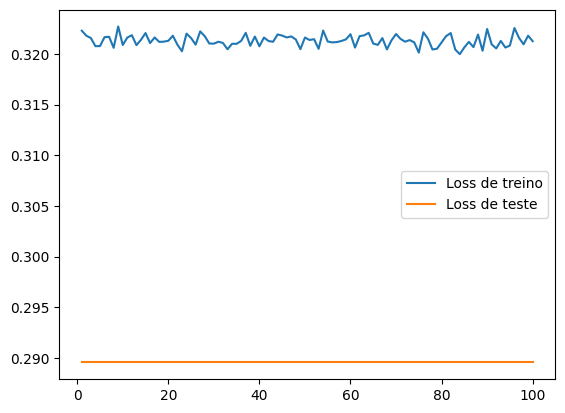

In [14]:
#Verificando as perdas na base de treino e de teste
x = np.linspace(1, epochs, epochs)
plt.plot(x, training_hist, scalex=False, label="Loss de treino")
plt.plot(x, test_hist, label='Loss de teste')
plt.legend()
plt.show()

In [15]:
#Momento de predição dos valores
passos_predicao = 50

#Conversão para NumPy
sequencia_plotagem = x_test.squeeze().cpu().numpy()

#Usando os ultimos 50 dias de dados como ponto de inicio
hist_data = sequencia_plotagem[-1]

#Lista para armazenagem dos valores
valores_preditos = []

#Predição dos valores
with torch.no_grad():
    for _ in range(passos_predicao*2):
        #Preparação do tensor par ao modelo
        hist_data_tensor = torch.as_tensor(hist_data).view(1,-1,1).float().to(device)
        
        #Modelo em funcionamento para predizer o próximo valor
        valor_predito = model(hist_data_tensor).cpu().numpy()[0,0]
        
        #Adicionando os valores preditos na lista criada anteriormente
        valores_preditos.append(valor_predito[0])
        
        #Atualizando os valores históticos para retirar o mais antigo e adicionar os valores preditos
        hist_data = np.roll(hist_data, shift=-1)
        hist_data[-1] = valor_predito

#Gerando data futura

ultima_data = df_reduced.iloc[math.ceil(len(df_reduced) * 0.8):len(df_reduced)].index[-1]

#Gerando próximos 15 dias
datas_futuras = pd.date_range(start=ultima_data + pd.DateOffset(1), periods=15)

#Combinando o index de datas original às datas futuras
index_combinado = df_reduced.iloc[math.ceil(len(df_reduced) * 0.8):len(df_reduced)].index.append(datas_futuras)

C:\Users\PICHAU\AppData\Local\Temp\ipykernel_14028\582773001.py:27: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  hist_data[-1] = valor_predito


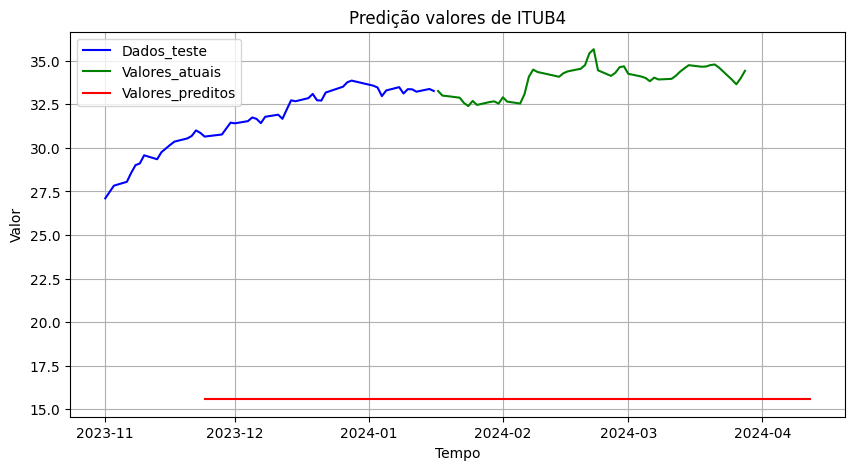

In [16]:
#Agora para melhor visualização é necessário plotar os valores
plt.rcParams['figure.figsize'] = [10,5]

#Plotagem dos dados de teste
plt.plot(df_reduced.iloc[math.ceil(len(df_reduced) * 0.8):len(df_reduced)].index[-100:-50], df_reduced.iloc[math.ceil(len(df_reduced) * 0.8):len(df_reduced)].Median[-100:-50], label = "Dados_teste", color = "b" )

#Reversão da escala dos dados
casos_originais = norm.inverse_transform(np.expand_dims(sequencia_plotagem[-1], axis=0)).flatten()

#Dados históricos usados como input na predição
plt.plot(df_reduced.iloc[math.ceil(len(df_reduced) * 0.8):len(df_reduced)].index[-50:], casos_originais, label='Valores_atuais', color='green')

#Valores preditos pelo modelo
#Reversão da escala de transformação
casos_preditos = norm.inverse_transform(np.expand_dims(valores_preditos, axis=0)).flatten()

#Plotando valores preditos
plt.plot(index_combinado[-100:], casos_preditos, label='Valores_preditos', color='red')

#
plt.xlabel('Tempo')
plt.ylabel('Valor')
plt.legend()
plt.title('Predição valores de ITUB4')
plt.grid(True)

In [21]:
#Estatísticas da predição
from sklearn.metrics import mean_squared_error
rmse = mean_squared_error(casos_originais,casos_preditos[:50], squared=False)
print(rmse)

valor_medio_original = np.mean(casos_originais)
valor_medio_predicao = np.mean(casos_preditos)
print(valor_medio_original)
print(valor_medio_predicao)

desvpad_originais = np.std(casos_originais)
desvpad_preditos = np.std(casos_preditos)
print(desvpad_originais)
print(desvpad_preditos)

Errpad_originais = desvpad_originais/len(casos_originais)
Errpad_preditos = desvpad_preditos/len(casos_preditos)
print(Errpad_originais)
print(Errpad_preditos)


18.330551
33.8929
15.581449
0.8365212
6.7434956e-07
0.016730424165725708
6.743495646333031e-09


d:\Documentos\Projetos\VS_Code workspace\Forecast_prediction\python_env_cuda_intel\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
